<a href="https://colab.research.google.com/github/deveshc23/HydroFinVision/blob/master/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


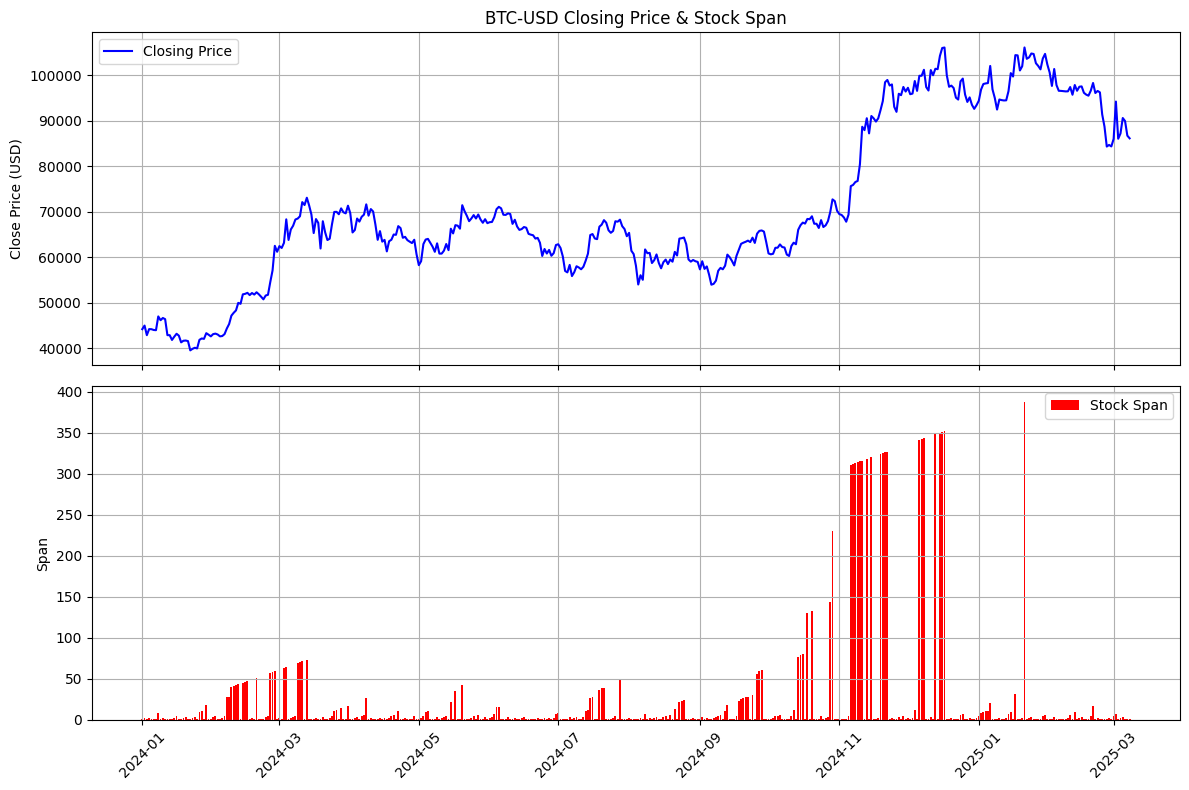

In [5]:
#Task 1
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

data = yf.download('BTC-USD', start='2024-01-01', end='2025-03-09')
data['Date'] = data.index

def calculate_stock_span(prices):
    span = [0] * len(prices)
    stack = []

    for i in range(len(prices)):
        while stack and prices[stack[-1]] <= prices[i]:
            stack.pop()
        span[i] = i + 1 if not stack else i - stack[-1]
        stack.append(i)

    return span
data['Span'] = calculate_stock_span(data['Close'].values)

fig, ax1 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax1[0].plot(data['Date'], data['Close'], color='blue', label='Closing Price')
ax1[0].set_ylabel("Close Price (USD)")
ax1[0].set_title("BTC-USD Closing Price & Stock Span")
ax1[0].legend()
ax1[0].grid(True)

ax1[1].bar(data['Date'], data['Span'], color='red', label='Stock Span')
ax1[1].set_ylabel("Span")
ax1[1].legend()
ax1[1].grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Final capital: $100000.00
Trade History:


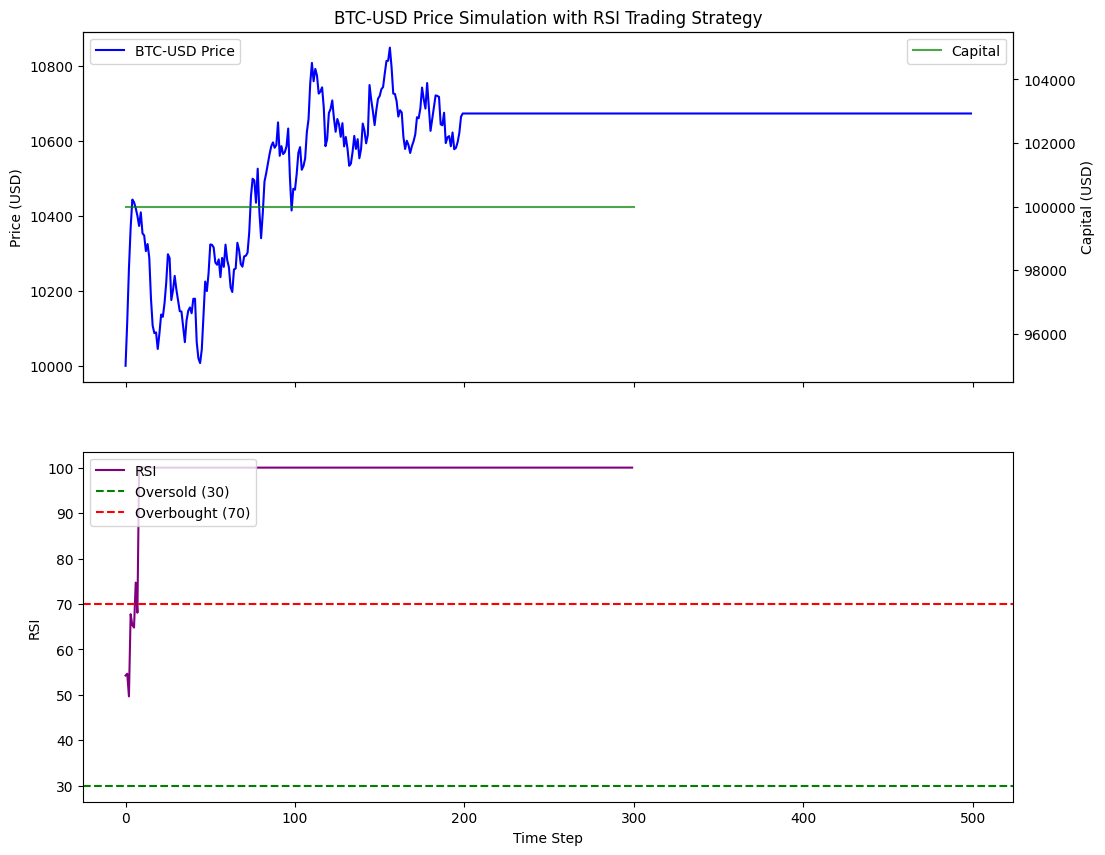

In [21]:
import math
import random
import matplotlib.pyplot as plt

# -------------------------
# Segment Tree Implementation
# -------------------------
class SegmentTree:
    def __init__(self, data, capacity):
        """
        Build a segment tree that supports range minimum (RMQ) and range maximum queries.
        'data' is the initial list of prices.
        'capacity' is the maximum number of elements (initial size + expected updates).
        """
        self.n = len(data)
        self.capacity = capacity

        # Compute the size of the tree (next power of 2)
        self.size_tree = 1
        while self.size_tree < self.capacity:
            self.size_tree *= 2

        # Initialize tree arrays for min and max
        self.tree_min = [float('inf')] * (2 * self.size_tree)
        self.tree_max = [float('-inf')] * (2 * self.size_tree)

        # Set initial leaves with provided data.
        for i in range(self.n):
            self.tree_min[self.size_tree + i] = data[i]
            self.tree_max[self.size_tree + i] = data[i]
        for i in range(self.n, self.size_tree):
            self.tree_min[self.size_tree + i] = float('inf')
            self.tree_max[self.size_tree + i] = float('-inf')

        # Build the tree bottom-up.
        for i in range(self.size_tree - 1, 0, -1):
            self.tree_min[i] = min(self.tree_min[2 * i], self.tree_min[2 * i + 1])
            self.tree_max[i] = max(self.tree_max[2 * i], self.tree_max[2 * i + 1])

    def update(self, index, value):
        """Update the price at a given index and refresh the tree."""
        pos = self.size_tree + index
        self.tree_min[pos] = value
        self.tree_max[pos] = value
        pos //= 2
        while pos >= 1:
            self.tree_min[pos] = min(self.tree_min[2 * pos], self.tree_min[2 * pos + 1])
            self.tree_max[pos] = max(self.tree_max[2 * pos], self.tree_max[2 * pos + 1])
            pos //= 2

    def append(self, value):
        """Append a new value to the data and update the tree."""
        if self.n >= self.capacity:
            raise Exception("Segment tree capacity exceeded.")
        self.update(self.n, value)
        self.n += 1

    def query_min(self, l, r):
        """Return the minimum price in the range [l, r] (0-indexed)."""
        res = float('inf')
        l += self.size_tree
        r += self.size_tree
        while l <= r:
            if l % 2 == 1:
                res = min(res, self.tree_min[l])
                l += 1
            if r % 2 == 0:
                res = min(res, self.tree_min[r])
                r -= 1
            l //= 2
            r //= 2
        return res

    def query_max(self, l, r):
        """Return the maximum price in the range [l, r] (0-indexed)."""
        res = float('-inf')
        l += self.size_tree
        r += self.size_tree
        while l <= r:
            if l % 2 == 1:
                res = max(res, self.tree_max[l])
                l += 1
            if r % 2 == 0:
                res = max(res, self.tree_max[r])
                r -= 1
            l //= 2
            r //= 2
        return res

# -------------------------
# RSI Calculation Function
# -------------------------
def calculate_rsi(prices, period=14):
    """
    Calculate the Relative Strength Index (RSI) using the simple moving average method.
    Returns RSI for the last period; if insufficient data, returns None.
    """
    if len(prices) < period + 1:
        return None  # Not enough data to compute RSI
    gains = []
    losses = []
    # Calculate differences for the last 'period' price changes.
    for i in range(-period, 0):
        delta = prices[i] - prices[i-1]
        if delta > 0:
            gains.append(delta)
            losses.append(0)
        else:
            gains.append(0)
            losses.append(-delta)
    avg_gain = sum(gains) / period
    avg_loss = sum(losses) / period

    if avg_loss == 0:
        return 100  # If no losses, RSI is 100 (overbought)
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# -------------------------
# BTC-USD Price Simulation and Trading Strategy using RSI
# -------------------------
def generate_btc_prices(n, start_price=10000, volatility=50):
    """Generate a simulated BTC-USD price series using a random walk."""
    prices = [start_price]
    for _ in range(1, n):
        change = random.gauss(0, volatility)
        new_price = max(0, prices[-1] + change)
        prices.append(new_price)
    return prices

# Simulation parameters
initial_n = 200            # initial number of prices
updates = 300              # number of new prices (updates)
total_points = initial_n + updates
capacity = total_points    # maximum capacity for our segment tree

# Generate simulated BTC-USD prices
prices = generate_btc_prices(initial_n)

# Build our segment tree using initial data
seg_tree = SegmentTree(prices, capacity)

# Trading simulation parameters
window_range = 50       # window size to query support/resistance levels
rsi_period = 14         # period for RSI calculation
capital = 100000        # initial capital in USD
position = 0            # BTC held (0 means no position)
entry_price = 0         # price at which position was entered
trade_history = []      # record of trades

# Lists to store simulation data for plotting
price_history = prices.copy()
capital_history = [capital]
rsi_history = []

# Trading thresholds
support_threshold = 0.01    # within 1% above support triggers buy signal
resistance_threshold = 0.01 # within 1% below resistance triggers sell signal
rsi_oversold = 30           # RSI threshold for oversold condition (buy signal)
rsi_overbought = 70         # RSI threshold for overbought condition (sell signal)

# Simulate updates and trading for each new price
for i in range(initial_n, total_points):
    # Generate a new BTC price based on the previous price
    new_price = generate_btc_prices(1, start_price=price_history[-1], volatility=50)[0]
    price_history.append(new_price)
    seg_tree.append(new_price)

    # Calculate RSI if enough data is available
    rsi = calculate_rsi(price_history, period=rsi_period)
    rsi_history.append(rsi if rsi is not None else 50)  # use a neutral 50 if not enough data

    # Only trade if we have at least 'window_range' data points for support/resistance
    if i >= window_range:
        l = i - window_range + 1
        r = i
        support = seg_tree.query_min(l, r)
        resistance = seg_tree.query_max(l, r)

        # Trading rules using RSI:
        # Buy if not in position, price is near support, and RSI indicates oversold (<30)
        if position == 0 and new_price <= support * (1 + support_threshold) and rsi is not None and rsi < rsi_oversold:
            position = capital / new_price
            entry_price = new_price
            capital = 0  # fully invest
            trade_history.append(('Buy', i, new_price, rsi))
            #print(f"Buy at {new_price:.2f} (RSI: {rsi:.2f}) on index {i}")
        # Sell if in position, price is near resistance, and RSI indicates overbought (>70)
        elif position > 0 and new_price >= resistance * (1 - resistance_threshold) and rsi is not None and rsi > rsi_overbought:
            capital = position * new_price
            trade_history.append(('Sell', i, new_price, rsi))
            position = 0
            #print(f"Sell at {new_price:.2f} (RSI: {rsi:.2f}) on index {i}")

    # Record current capital (if holding, use mark-to-market value)
    current_value = capital if position == 0 else position * new_price
    capital_history.append(current_value)

# Close any open position at the end of simulation
if position > 0:
    capital = position * price_history[-1]
    trade_history.append(('Final Sell', total_points - 1, price_history[-1], calculate_rsi(price_history, period=rsi_period)))
    position = 0

# -------------------------
# Simulation Results and Analysis
# -------------------------
print("Final capital: ${:.2f}".format(capital))
print("Trade History:")
for trade in trade_history:
    print(trade)

# Plot price history, RSI, and capital evolution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

# Plot BTC-USD price and support/resistance window visualization
ax1.plot(price_history, label="BTC-USD Price", color="blue")
ax1.set_ylabel("Price (USD)")
ax1.legend(loc="upper left")
ax1.set_title("BTC-USD Price Simulation with RSI Trading Strategy")

# Plot RSI history
# For plotting RSI, pad the beginning with None or a neutral value if needed.
ax2.plot(range(len(rsi_history)), rsi_history, label="RSI", color="purple")
ax2.axhline(y=rsi_oversold, color="green", linestyle="--", label="Oversold (30)")
ax2.axhline(y=rsi_overbought, color="red", linestyle="--", label="Overbought (70)")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Time Step")
ax2.legend(loc="upper left")

# Create a twin axis to plot capital on the price plot
ax3 = ax1.twinx()
ax3.plot(capital_history, label="Capital", color="green", alpha=0.7)
ax3.set_ylabel("Capital (USD)")
ax3.legend(loc="upper right")

plt.show()
